In [1]:
# ADNI Diagnosis-Based Subject Sampling and Splitting Notebook

# This notebook filters and samples subjects from ADNIMERGE clinical data,
# balances across CN, MCI, AD groups, and splits into train/val/test sets.

import pandas as pd
from sklearn.model_selection import train_test_split

In [2]:
# ---- Step 1: Load ADNIMERGE data from GitHub ----
url = "https://raw.githubusercontent.com/treyschulman/cs598dlh_project/main/data/ADNIMERGE_17Apr2025.csv"
df = pd.read_csv(url)

<ipython-input-2-60d16ce2ea74>:3: DtypeWarning: Columns (19,20,21,50,51,104,105,106) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(url)


In [4]:
# ---- Step 2: Filter to baseline visit only ----
df_bl = df[df["VISCODE"] == "bl"]

In [5]:
# ---- Step 3: Keep necessary columns and drop missing values ----
columns_to_keep = ["RID", "PTID", "DX_bl", "AGE", "PTGENDER"]
df_bl_filtered = df_bl[columns_to_keep].dropna(subset=["DX_bl", "AGE", "PTGENDER"])

In [6]:
# ---- Step 4: Normalize diagnosis labels ----
df_bl_filtered["DX_bl"] = df_bl_filtered["DX_bl"].replace({"EMCI": "MCI", "LMCI": "MCI"})

In [7]:
# ---- Step 5: Keep only CN, MCI, AD groups ----
df_bl_filtered = df_bl_filtered[df_bl_filtered["DX_bl"].isin(["CN", "MCI", "AD"])]

In [8]:
# ---- Step 6: Sample 15 subjects per class ----
sampled_df = df_bl_filtered.groupby("DX_bl", group_keys=False).apply(lambda x: x.sample(15, random_state=42))

<ipython-input-8-ae44be255a5b>:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = df_bl_filtered.groupby("DX_bl", group_keys=False).apply(lambda x: x.sample(15, random_state=42))


In [9]:
# ---- Step 7: Stratified split into train (70%), val (15%), test (15%) ----
train_val_df, test_df = train_test_split(sampled_df, test_size=0.15, stratify=sampled_df["DX_bl"], random_state=42)
train_df, val_df = train_test_split(train_val_df, test_size=0.1765, stratify=train_val_df["DX_bl"], random_state=42)

In [10]:
# ---- Step 8: Tag split and combine ----
train_df = train_df.copy(); train_df["Split"] = "Train"
val_df = val_df.copy(); val_df["Split"] = "Validation"
test_df = test_df.copy(); test_df["Split"] = "Test"

In [11]:
final_df = pd.concat([train_df, val_df, test_df]).sort_values(by=["Split", "DX_bl"])

In [12]:
# ---- Step 9: Save split files ----
final_df.to_csv("adni_subject_splits.csv", index=False)
train_df.to_csv("train_subjects.csv", index=False)
val_df.to_csv("val_subjects.csv", index=False)
test_df.to_csv("test_subjects.csv", index=False)

In [13]:
# ---- Step 10: Display summary ----
print("\nFinal Split Counts:")
print(final_df.groupby(["Split", "DX_bl"]).size())

final_df.head()


Final Split Counts:
Split       DX_bl
Test        AD        2
            CN        2
            MCI       3
Train       AD       10
            CN       11
            MCI      10
Validation  AD        3
            CN        2
            MCI       2
dtype: int64


,RID,PTID,DX_bl,AGE,PTGENDER,Split
13044,6768,013_S_6768,AD,78.4,Female,Test
1756,850,027_S_0850,AD,78.1,Male,Test
952,419,010_S_0419,CN,70.2,Male,Test
14712,6211,032_S_6211,CN,80.6,Male,Test
11575,957,057_S_0957,MCI,74.0,Male,Test


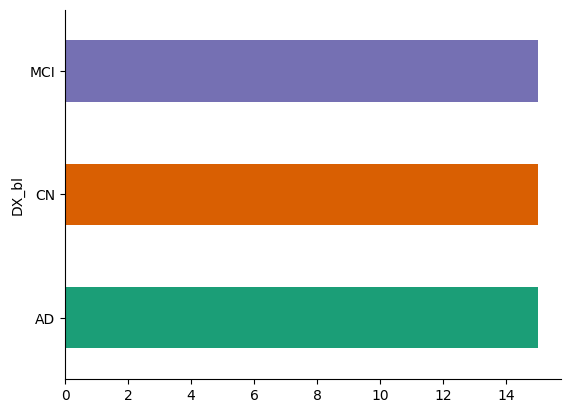

In [16]:
# @title DX_bl

from matplotlib import pyplot as plt
import seaborn as sns
final_df.groupby('DX_bl').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

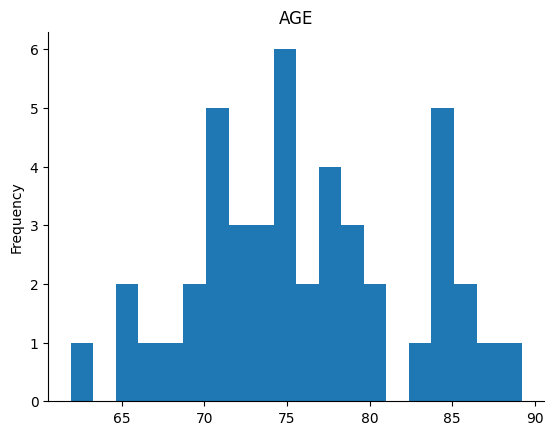

In [15]:
# @title AGE

from matplotlib import pyplot as plt
final_df['AGE'].plot(kind='hist', bins=20, title='AGE')
plt.gca().spines[['top', 'right',]].set_visible(False)

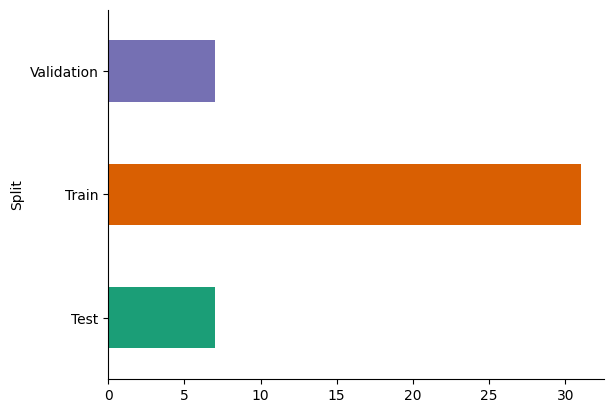

In [14]:
# @title Split
from matplotlib import pyplot as plt
import seaborn as sns
final_df.groupby('Split').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [21]:
# import requests
# import os
# import base64

# # Replace with your actual PAT (stored securely)
# GITHUB_PAT = "removed"
# REPO_OWNER = "treyschulman"
# REPO_NAME = "cs598dlh_project"
# BRANCH = "main"
# DATA_PATH = "data"  # Path within the repository

# def upload_to_github(df, filename):
#     """Uploads a DataFrame to a GitHub repository as a CSV file."""
#     file_content = df.to_csv(index=False)  # Convert DataFrame to CSV string
#     # Encode the file content to Base64
#     encoded_content = base64.b64encode(file_content.encode()).decode()
#     url = f"https://api.github.com/repos/{REPO_OWNER}/{REPO_NAME}/contents/{DATA_PATH}/{filename}"
#     headers = {
#         "Authorization": f"token {GITHUB_PAT}",
#         "Content-Type": "application/vnd.github.v3+json"
#     }
#     data = {
#         "message": f"Update {filename}",
#         "content": encoded_content,  # Note: base64 encoding might be needed
#         "branch": BRANCH
#     }
#     response = requests.put(url, headers=headers, json=data)
#     if response.status_code == 200 or response.status_code == 201:  # Success
#         print(f"Uploaded {filename} to GitHub successfully.")
#     else:
#         print(f"Error uploading {filename} to GitHub: {response.status_code}")
#         print(response.json())  # Print error details

# # Upload DataFrames
# upload_to_github(final_df, "adni_subject_splits.csv")
# upload_to_github(train_df, "train_subjects.csv")
# upload_to_github(val_df, "val_subjects.csv")
# upload_to_github(test_df, "test_subjects.csv")

Uploaded adni_subject_splits.csv to GitHub successfully.
Uploaded train_subjects.csv to GitHub successfully.
Uploaded val_subjects.csv to GitHub successfully.
Uploaded test_subjects.csv to GitHub successfully.
